# XGBoost optimization

In [1]:
settings = {
                "dataset":"data_after_cleaning.csv",
                "columns_dataset": "scores_after_multicol.csv",           
                "scoring_type":'neg_mean_absolute_error',
                "cross_val_times":2,
                "datapoints":60000, #fill in all if you want to use all datapoints,
                "allow_creating_new_results_df":True, #only allow making new results df when True (risky to keep on true after testing)
                "threshold_xgboost": 0.1#0.006535948

}

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import winsound
from sklearn.model_selection import cross_validate
from sklearn import metrics#Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from xgboost.sklearn import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
data = pd.read_csv('data/' + settings["dataset"])


# columns = [column for column in pd.read_csv('data/'+settings["columns_dataset"])["features"].values if column != 'Intercept']

columns = list(data.columns)
columns.append("close_price_next_min") 
final_columns = [column for column in columns if column!="close_price_next_min"]
X = data[final_columns].values
y = data["close_price_next_min"].values

In [4]:
#if order matters:

data2 = data[:60000]
data2
data2['difference'] = data2['close_price_next_min']-data2['ETHBTC__ticker_info__close_price']
data2['dummy_next_start_time'] = data2['difference'].apply(lambda x: 1 if x > 0 else 0) 
data2 = data2.drop(columns=['difference','close_price_next_min','last_start_time'])

# y2= data2['close_price_next_min']
# X2 = data2.drop(columns=['close_price_next_min'])

# X_train, X_test = X2.loc[:int(0.8*len(data2))], X2.loc[int(0.8*len(data2)):]
# y_train, y_test = y2.loc[:int(0.8*len(data2))], y2.loc[int(0.8*len(data2)):]

train = data2.loc[:int(0.8*len(data2))-1]
test = data2.loc[len(train):]
test_results = pd.DataFrame(test['dummy_next_start_time'])
test = test.drop(columns=['dummy_next_start_time'])

C:\Users\lexfo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\lexfo\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
data2

,ETHBTC__technical_analysis_candles__rsi,ETHBTC__technical_analysis_candles__macd,ETHBTC__technical_analysis_candles__signal,ETHBTC__technical_analysis_candles__macdhist,ETHBTC__technical_analysis_candles__sma_5,ETHBTC__technical_analysis_candles__sma_10,ETHBTC__technical_analysis_candles__sma_21,ETHBTC__technical_analysis_candles__sma_50,ETHBTC__technical_analysis_candles__sma_100,ETHBTC__technical_analysis_candles__sma_200,...,general_info__exchange_info__Turkish_Lira,general_info__exchange_info__New_Taiwan_Dollar,general_info__exchange_info__Ukrainian_hryvnia,general_info__exchange_info__Venezuelan_bolivar_fuerte,general_info__exchange_info__Vietnamese_dong,general_info__exchange_info__South_African_Rand,general_info__exchange_info__IMF_Special_Drawing_Rights,general_info__exchange_info__Silver_Troy_Ounce,general_info__exchange_info__Gold_Troy_Ounce,dummy_next_start_time
0,36.739428,-0.000003,-6.158753e-08,3.061318e-06,0.021819,0.021829,0.021828,0.021830,0.021792,0.021746,...,58304.408,292569.228,239251.021,2.420021e+09,2.266090e+08,144919.089,7082.754,546.108,6.221,1
1,36.364695,-0.000005,-1.014827e-06,3.812957e-06,0.021811,0.021827,0.021826,0.021829,0.021792,0.021746,...,58303.749,292539.523,239246.639,2.419976e+09,2.266805e+08,144894.981,7082.624,546.098,6.222,1
2,35.957189,-0.000006,-2.049515e-06,4.138754e-06,0.021808,0.021823,0.021824,0.021829,0.021793,0.021746,...,58309.177,292566.759,239268.913,2.420202e+09,2.267016e+08,144908.471,7083.283,546.148,6.223,1
3,30.947809,-0.000008,-3.283751e-06,4.936942e-06,0.021800,0.021817,0.021823,0.021828,0.021794,0.021747,...,58317.066,292606.338,239301.282,2.420529e+09,2.267322e+08,144928.074,7084.242,546.222,6.224,1
4,30.583641,-0.000010,-4.586828e-06,5.212308e-06,0.021794,0.021811,0.021820,0.021827,0.021795,0.021747,...,58328.985,292666.141,239350.191,2.421024e+09,2.267786e+08,144957.695,7085.690,546.334,6.225,1
5,28.358945,-0.000011,-5.950016e-06,5.452753e-06,0.021790,0.021805,0.021819,0.021826,0.021796,0.021748,...,58328.985,292666.141,239350.191,2.421024e+09,2.267786e+08,144957.695,7085.690,546.334,6.225,1
6,26.569413,-0.000013,-7.345631e-06,5.582460e-06,0.021785,0.021798,0.021816,0.021825,0.021797,0.021748,...,58337.416,292685.822,239366.279,2.421186e+09,2.267595e+08,144868.296,7086.166,546.251,6.224,1
7,22.472700,-0.000015,-8.879076e-06,6.133777e-06,0.021777,0.021792,0.021812,0.021823,0.021799,0.021748,...,58336.678,292682.119,239363.250,2.421156e+09,2.267567e+08,144866.463,7086.076,546.244,6.224,1
8,23.481108,-0.000016,-1.038233e-05,6.013023e-06,0.021772,0.021786,0.021809,0.021822,0.021800,0.021748,...,58340.526,292701.425,239379.039,2.421315e+09,2.267716e+08,144876.019,7086.544,546.280,6.225,0
9,31.411269,-0.000017,-1.163656e-05,5.016929e-06,0.021769,0.021782,0.021806,0.021821,0.021801,0.021749,...,58333.643,292666.890,239350.795,2.421030e+09,2.267449e+08,144858.925,7085.707,546.216,6.224,0


In [6]:
target ='dummy_next_start_time'
IDcol= 'last_start_time'

In [7]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50,errortype='auc'):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,metrics=errortype, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=errortype)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print (errortype,"Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
#     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest['predprob'], left_index= True,right_index=True)
    print(errortype,'Score (Test): %f' % metrics.roc_auc_score(results[target], results['predprob']))
         
#     print(alg)
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.iloc[:50].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return feat_imp

### visualize without optimization


Model Report
Accuracy : 0.9594
auc Score (Train): 0.993367
auc Score (Test): 0.788949


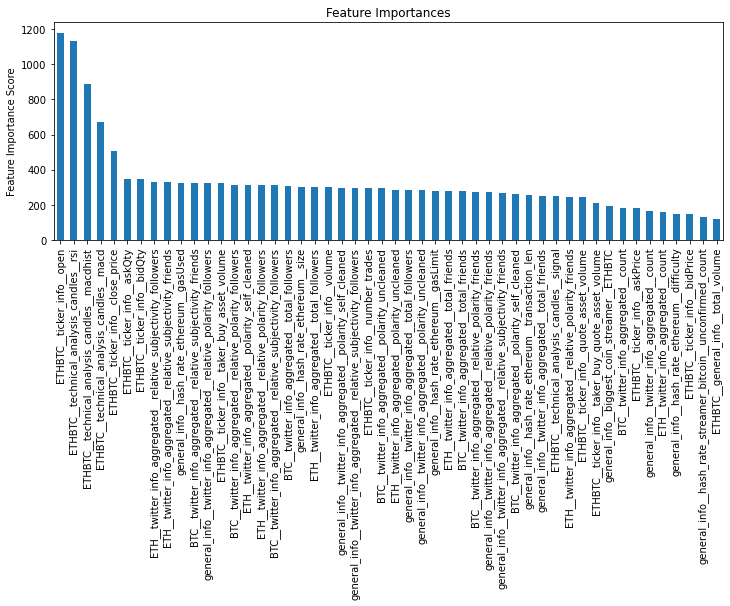

In [8]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=2)

features = modelfit(xgb1, train, test, predictors,errortype='auc')



###  optimization max depth / min child weight

In [9]:
param_test1 = {
    'max_depth':range(1,10,2),
    'min_child_weight':range(1,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
                                                learning_rate =0.1, 
                                                n_estimators=345, 
                                                max_depth=5,
                                                min_child_weight=1, 
                                                gamma=0, 
                                                subsample=0.8, 
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic', 
                                                nthread=4, 
                                                scale_pos_weight=1, 
                                                seed=2), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train[predictors],train[target])
# print(gsearch1.cv_results_, gsearch1.best_score_)
print('---------------------')
print(gsearch1.best_params_)

---------------------
{'max_depth': 9, 'min_child_weight': 7}


In [10]:
param_test2 = {
 'max_depth':[gsearch1.best_params_['max_depth']-1,gsearch1.best_params_['max_depth'],gsearch1.best_params_['max_depth']+1],
 'min_child_weight':[gsearch1.best_params_['min_child_weight']-1,gsearch1.best_params_['min_child_weight'],gsearch1.best_params_['min_child_weight']+1]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, 
                                                  n_estimators=345, 
                                                  max_depth=5,
                                                  min_child_weight=2, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=2), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
# print(gsearch2.cv_results_, gsearch2.best_score_)
print('---------------------')
print(gsearch2.best_params_)

---------------------
{'max_depth': 10, 'min_child_weight': 7}


In [11]:
max_depth = gsearch2.best_params_['max_depth']
min_child_weight = gsearch2.best_params_['min_child_weight']

###  optimization gamma

In [12]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=345, 
                                                  max_depth=max_depth,
                                                  min_child_weight=min_child_weight,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=2), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
# print(gsearch3.cv_results_, gsearch3.best_score_)
print('------------------------')
gsearch3.best_params_

------------------------


{'gamma': 0.9}

In [13]:
gamma = gsearch3.best_params_['gamma']

### visualize with max depth, min child and gamma optimized


Model Report
Accuracy : 1
auc Score (Train): 1.000000
auc Score (Test): 0.804189


ETHBTC__technical_analysis_candles__rsi                                   2845
ETHBTC__technical_analysis_candles__macdhist                              2514
ETHBTC__ticker_info__open                                                 2343
ETHBTC__technical_analysis_candles__macd                                  2085
ETHBTC__ticker_info__askQty                                               1081
ETHBTC__ticker_info__bidQty                                               1060
BTC__twitter_info_aggregated__relative_polarity_followers                 1054
ETH__twitter_info_aggregated__relative_subjectivity_friends               1026
ETH__twitter_info_aggregated__polarity_self_cleaned                       1015
general_info__twitter_info_aggregated__relative_polarity_followers        1011
BTC__twitter_info_aggregated__relative_subjectivity_friends               1011
ETH__twitter_info_aggregated__relative_subjectivity_followers             1001
BTC__twitter_info_aggregated__relative_subjectivity_

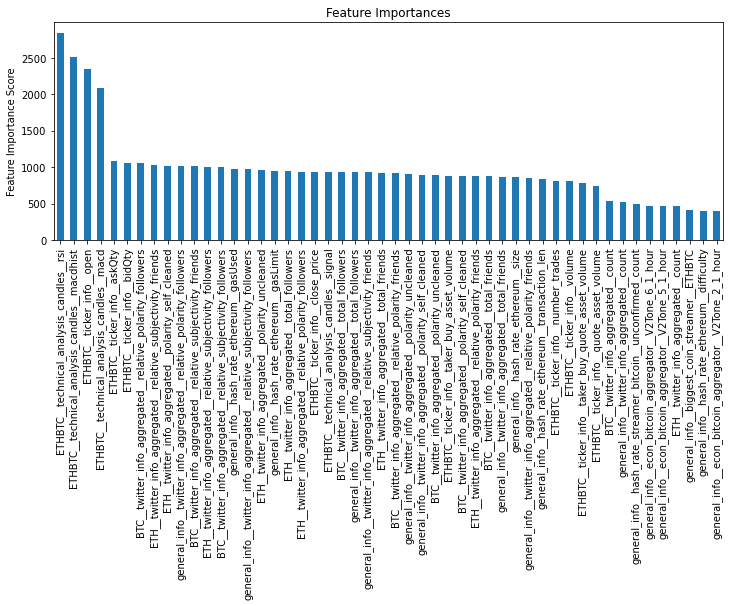

In [14]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
                learning_rate =0.1,
                n_estimators=1000,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                gamma=gamma,
                subsample=0.8,
                colsample_bytree=0.8,
                objective= 'binary:logistic',
                nthread=4,
                scale_pos_weight=1,
                seed=2)
modelfit(xgb2, train,test, predictors)

### optimizing subsample and colsample bytree

In [15]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=345, 
                                                  max_depth=max_depth,
                                                  min_child_weight=min_child_weight,
                                                  gamma=gamma,
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=2), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
# print(gsearch4.cv_results_, gsearch4.best_score_)

print('------------------------')
gsearch4.best_params_

------------------------


{'colsample_bytree': 0.8, 'subsample': 0.8}

In [16]:
param_test5 = {
    'colsample_bytree':[gsearch4.best_params_['colsample_bytree']-0.05,gsearch4.best_params_['colsample_bytree'],gsearch4.best_params_['colsample_bytree']+0.05],
    'subsample':[gsearch4.best_params_['subsample']-0.05,gsearch4.best_params_['subsample'],gsearch4.best_params_['subsample']+0.05]
 
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,
                                                  n_estimators=345,
                                                  max_depth=max_depth,
                                                  min_child_weight=min_child_weight,
                                                  gamma=gamma, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=2), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
# print(gsearch5.cv_results_, gsearch5.best_score_)

print('------------------------')
gsearch5.best_params_

------------------------


{'colsample_bytree': 0.8, 'subsample': 0.8}

In [17]:
colsample_bytree = gsearch5.best_params_['colsample_bytree']
subsample = gsearch5.best_params_['subsample']

### visualize with max depth, min child, gamma, subsample, and colsample optimized


Model Report
Accuracy : 1
auc Score (Train): 1.000000
auc Score (Test): 0.804189


ETHBTC__technical_analysis_candles__rsi                                   2845
ETHBTC__technical_analysis_candles__macdhist                              2514
ETHBTC__ticker_info__open                                                 2343
ETHBTC__technical_analysis_candles__macd                                  2085
ETHBTC__ticker_info__askQty                                               1081
ETHBTC__ticker_info__bidQty                                               1060
BTC__twitter_info_aggregated__relative_polarity_followers                 1054
ETH__twitter_info_aggregated__relative_subjectivity_friends               1026
ETH__twitter_info_aggregated__polarity_self_cleaned                       1015
general_info__twitter_info_aggregated__relative_polarity_followers        1011
BTC__twitter_info_aggregated__relative_subjectivity_friends               1011
ETH__twitter_info_aggregated__relative_subjectivity_followers             1001
BTC__twitter_info_aggregated__relative_subjectivity_

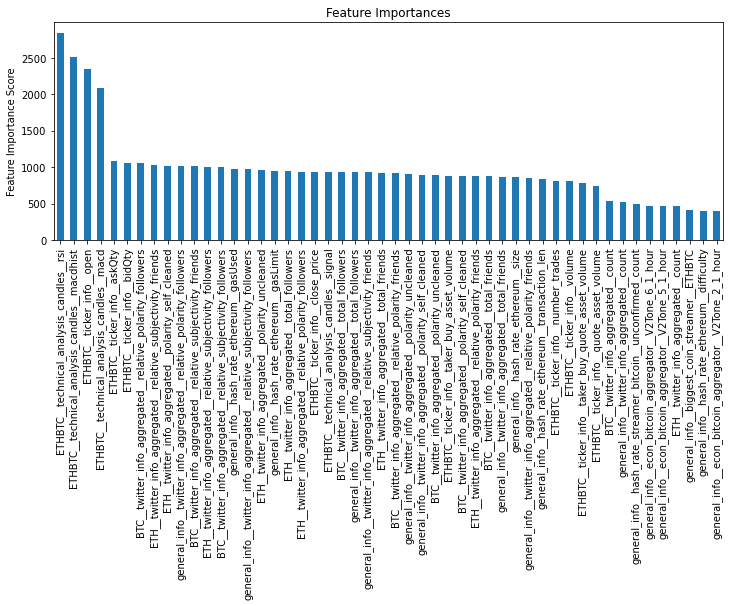

In [18]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb3 = XGBClassifier(
                learning_rate =0.1,
                n_estimators=1000,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective= 'binary:logistic',
                nthread=4,
                scale_pos_weight=1,
                seed=2)
modelfit(xgb3, train,test, predictors)

In [19]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=345, 
                                                  max_depth=max_depth,
                                                  min_child_weight=min_child_weight, 
                                                  gamma=gamma, 
                                                  subsample=subsample, 
                                                  colsample_bytree=colsample_bytree,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=2), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
# print(gsearch6.cv_results_, gsearch6.best_score_)
print('------------------------')
gsearch6.best_params_

------------------------


{'reg_alpha': 100}

In [20]:
param_test7 = {
 'reg_alpha':[gsearch6.best_params_['reg_alpha']/2,gsearch6.best_params_['reg_alpha'],gsearch6.best_params_['reg_alpha']*2 ]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=345, 
                                                  max_depth=max_depth,
                                                  min_child_weight=min_child_weight, 
                                                  gamma=gamma, 
                                                  subsample=subsample, 
                                                  colsample_bytree=colsample_bytree,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=2), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.fit(train[predictors],train[target])
# print(gsearch7.cv_results_, gsearch7.best_score_)
print('------------------------')
gsearch7.best_params_

------------------------


{'reg_alpha': 100}

In [21]:
reg_alpha = gsearch7.best_params_['reg_alpha']


Model Report
Accuracy : 0.8038
auc Score (Train): 0.890945
auc Score (Test): 0.802310


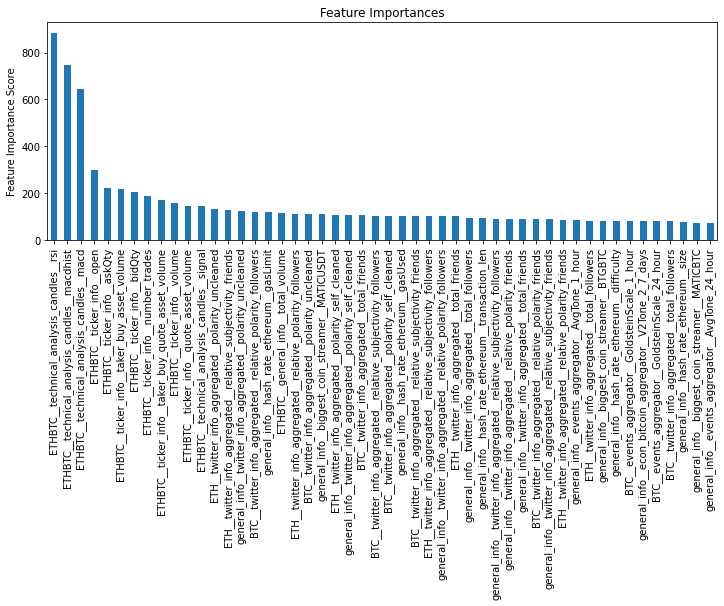

In [22]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb4 = XGBClassifier(
                learning_rate =0.1,
                n_estimators=1000,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective= 'binary:logistic',
                reg_alpha=reg_alpha,
                nthread=4,
                scale_pos_weight=1,
                seed=2)
ttt = modelfit(xgb4, train,test, predictors)


Model Report
Accuracy : 0.9999
auc Score (Train): 1.000000
auc Score (Test): 0.811773


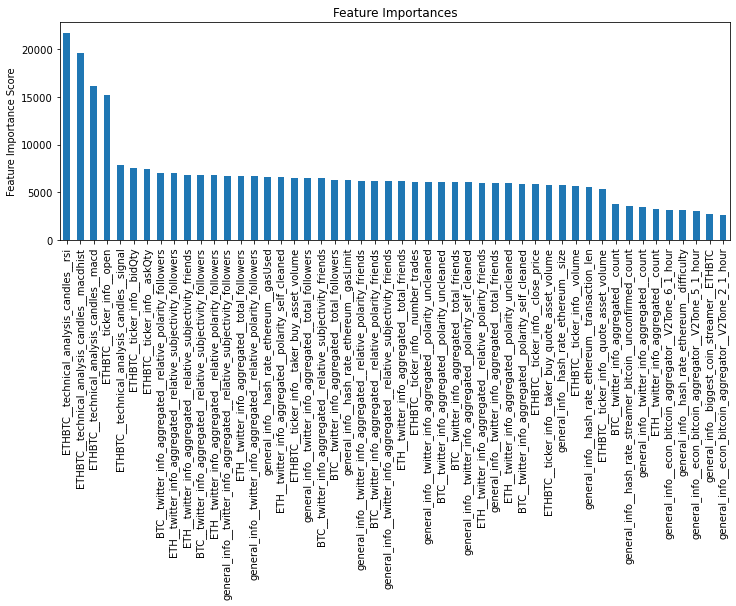

In [23]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb6 = XGBClassifier(
                learning_rate =0.01,
                n_estimators=5000,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective= 'binary:logistic',
                nthread=4,
                reg_alpha=0.005,
                scale_pos_weight=1,
                seed=2)
features_final6 = modelfit(xgb6, train,test, predictors)

In [ ]:
features_final6

In [ ]:
def write_as_log(title,data):
    '''
    Function can be used to write a log in the logs folder. 
    Data has to be an array 
    '''
    with open(f'results/Feature_importance_ranking/{title}.txt','w') as temp:
        if type(data) == list:
            for row in data:
                temp.write(str(row))
                temp.write('\n')

In [ ]:
features_XGboost = list(features_final6.index)

In [ ]:
write_as_log('test_xg_boost', features_XGboost)

In [ ]:
features_final6

In [ ]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb6 = XGBClassifier(
                learning_rate =0.01,
                n_estimators=5000,
                max_depth=10,
                min_child_weight=10,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                objective= 'binary:logistic',
                nthread=4,
                reg_alpha=0.005,
                scale_pos_weight=1,
                seed=2)
features_final6 = modelfit(xgb6, train,test, predictors)

In [ ]:
features_final6

In [ ]:
XGBoost_importance_ranking = pd.DataFrame()
features = features_final6.index
importance = list(features_final6)

XGBoost_importance_ranking['var'] = features
XGBoost_importance_ranking['imp'] = importance

In [ ]:
XGBoost_importance_ranking

In [ ]:
# XGBoost_importance_ranking.to_csv(r'results/Feature_importance_ranking/XGBoost_ranking_rerun.csv', index = False)